In [1]:
import numpy as np
import re
import subprocess
import matplotlib.pyplot as plt
import matplotlib 
import astropy.units as u
from astropy.io import fits
from astropy.constants import m_p, M_sun

import os
gd_folder = os.getcwd()+"/../../Calculations/SKIRTOR/"

import sys 
sys.path.append(gd_folder)
#from loadSKIRTOR_MRN77 import LoadSKIRTOR_MRN77
from loadSKIRTOR_MRN77_force_reg import LoadSKIRTOR_MRN77
from loadSKIRTOR_General import LoadSKIRTOR_General

sys.path.append("../utility_functions/")
from objectProperties import ObjectProperties
from readExtrapolatedSpectra import ReadExtrapolatedSpectra

sys.path.append("../../Filter_Curves/")
from readBands import ReadBands

In [2]:
#general_method_interp = "linear"
general_method_interp = "pchip"

In [3]:
#Use the latex font when plotting. 
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [4]:
#Set the object ID.
wid = "W0204-0506"

In [5]:
#Load the object properties.
op = ObjectProperties([wid])

In [6]:
#Load the bands.
bands = ReadBands()
for bname in bands.bandnames:
    print(bname, bands.bp[bname].barlam(), bands.bp[bname].fwhm(), bands.bp[bname].rectwidth())

R_SPECIAL 6501.229535920617 Angstrom 1159.881393925198 Angstrom 1624.9974574790472 Angstrom
I_BESS 7925.773360798338 Angstrom 1080.5202412457434 Angstrom 1433.1539789444323 Angstrom
v_HIGH 5531.691038305597 Angstrom 850.6231300284223 Angstrom 1195.0838113345558 Angstrom


In [7]:
#Load the spectra for each BHD, extended using the best-fit SED.
specs = ReadExtrapolatedSpectra([wid])

Wavelength range for object W0019-1046 limited because of sky template
Spec-range: 3001.5 Angstrom - 5423.93 Angstrom
Sky-range: 3199.4 Angstrom - 6724.06 Angstrom
Wavelength range for object W0204-0506 limited because of sky template
Spec-range: 3786.2 Angstrom - 6672.70 Angstrom
Sky-range: 3789.3 Angstrom - 6682.76 Angstrom
Warning, 2 of 3161 bins contained negative fluxes; they have been set to zero.
Wavelength range for object W0831+0140 limited because of sky template
Spec-range: 3786.2 Angstrom - 6672.45 Angstrom
Sky-range: 3789.3 Angstrom - 6682.76 Angstrom
Warning, 2 of 3161 bins contained negative fluxes; they have been set to zero.


In [8]:
#Read the MRN77 chi2 map. 
p_map = dict()
chi2_map = dict()
pws = dict()
cone_types = ["Top", "Bottom", "Full"]
for cone_type in cone_types:
    pws[cone_type] = LoadSKIRTOR_MRN77(cone_type=cone_type, interp_method=general_method_interp)

pws_linear = dict()
for cone_type in cone_types:
    pws_linear[cone_type] = LoadSKIRTOR_MRN77(cone_type=cone_type, interp_method='linear')

bands_use = list()
p_meas = list()
p_unc = list()
for band in op.pfrac[wid].keys():
    bands_use.append(bands.bp[band])
    p_meas.append(op.pfrac[wid][band])
    p_unc.append(op.epfrac[wid][band])

chi2_map[wid] = dict()
for cone_type in cone_types:
    if cone_type=="Full":
        fname = "../SKIRTOR_fit/maps/chi2_map_{}.fits".format(wid)
    else:
        fname = "maps_{}Cone/chi2_map_{}.fits".format(cone_type, wid)
    h = fits.open(fname)
    tang_grid = np.array(h[0].header['TANGGRID'].split()).astype(float)
    tang_grid = tang_grid * u.Unit(h[0].header['TANGUNIT'])
    cang_grid = np.array(h[0].header['CANGGRID'].split()).astype(float)
    cang_grid = cang_grid * u.Unit(h[0].header['CANGUNIT'])
    iang_grid = np.array(h[0].header['IANGGRID'].split()).astype(float)
    iang_grid = iang_grid * u.Unit(h[0].header['IANGUNIT'])
    chi2_map[wid][cone_type] = np.ma.zeros((len(tang_grid), len(cang_grid), len(iang_grid)))
    chi2_map[wid][cone_type][:,:,:] = h[0].data
    chi2_map[wid][cone_type].mask = h[1].data.astype(bool)


In [9]:
#Find the best solution for W0204-0506
for cone_type in cone_types:
    i, j, k = np.unravel_index(np.argmin(chi2_map[wid][cone_type], axis=None), chi2_map[wid][cone_type].shape)
    print(cone_type, tang_grid[i], cang_grid[j], iang_grid[k], chi2_map[wid][cone_type].min())

Top 32.5 deg 21.0 deg 56.0 deg 7.689583731337499e-10
Bottom 50.0 deg 35.5 deg 61.0 deg 1.4407787221813311e-08
Full 28.0 deg 15.0 deg 48.5 deg 3.83571358380841e-08


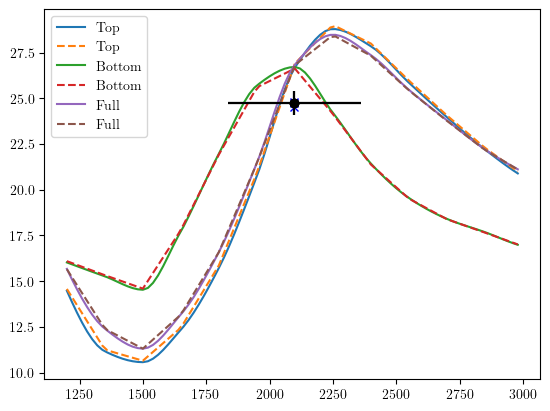

In [10]:
#Make a quick plot comparing linear and pchip interpolation. 
lam_grid = np.arange(1200., 3000., 20.)*u.AA

for cone_type in cone_types:
    i, j, k = np.unravel_index(np.argmin(chi2_map[wid][cone_type], axis=None), chi2_map[wid][cone_type].shape)
    plt.plot(lam_grid, 100*pws[cone_type].p((tang_grid[i]*np.ones(lam_grid.shape), cang_grid[j]*np.ones(lam_grid.shape), iang_grid[k]*np.ones(lam_grid.shape), lam_grid)), label=cone_type)
    plt.plot(lam_grid, 100*pws_linear[cone_type].p((tang_grid[i]*np.ones(lam_grid.shape), cang_grid[j]*np.ones(lam_grid.shape), iang_grid[k]*np.ones(lam_grid.shape), lam_grid)), label=cone_type, linestyle='dashed')

    for bname in op.pfrac[wid].keys():
        plt.errorbar([bands.bp[bname].barlam().value/(1+op.z[wid])], [op.pfrac[wid][bname]], xerr=[bands.bp[bname].rectwidth().value/2./(1+op.z[wid])], yerr=[op.epfrac[wid][bname]], marker='o', color='k')

        p_mod = pws[cone_type].p_bb(bands.bp[bname], tang_grid[i:i+1], cang_grid[j:j+1], iang_grid[k:k+1], specs.lam_obs[wid], specs.flam[wid], op.z[wid])
        plt.plot([bands.bp[bname].barlam().value/(1+op.z[wid])], [p_mod[0,0,0]*100], 'bx')

plt.legend()

In [11]:
#Now, only do some selected models for the main Figure of the W0204-0506 paper. 
#Set the additional SKIRTOR models we want to plot for W0204-0506
other_sk_models = [

    #Draine (2003) models
    {"d03_mod":"MW" , "ls":'dotted', "label":"Draine (2003) Mixtures"},
    {"d03_mod":"LMC", "ls":'dotted', "label":None},
    {"d03_mod":"SMC", "ls":'dotted', "label":None},

    #MRN77_gra models
    # {"gs_min":0.005, "gs_max":0.25, "a":0.0, "ls":"dashed", "label":None},
    # {"gs_min":0.005, "gs_max":0.25, "a":2.0, "ls":"dashed", "label":None},
    # {"gs_min":0.005, "gs_max":0.25, "a":3.5, "ls":"dashed", "label":r"$\rm MRN77_{\rm gra}$"},

    #MRN77_gra+sil models
    {"gs_min":0.005, "gs_max":0.25, "a":3.5, "sil":True,"ls":"solid", "label":r'$\rm MRN77_{\rm gra+\rm sil}$'},

    #Large grain models gra only
    # {"gs_min":0.1, "gs_max":1, "a":0.0, "ls":"dotted", "label":"Large grains"},
    # {"gs_min":0.1, "gs_max":1, "a":0.5, "ls":"dotted", "label":"Large grains"},
    # {"gs_min":0.1, "gs_max":1, "a":1.5, "ls":"dotted", "label":"Large grains"},
    # {"gs_min":0.1, "gs_max":1, "a":2.5, "ls":"dotted", "label":"Large grains"},
    # {"gs_min":0.1, "gs_max":1, "a":3.5, "ls":"dotted", "label":"Large grains"},

    #Large grain models wit silicates.
    {"gs_min":0.1, "gs_max":1 , "a":3.5, "sil":True, "ls":"dashed", "label":None},
    {"gs_min":1  , "gs_max":10, "a":3.5, "sil":True, "ls":"dashed", "label":r"Large grains$_{\rm gra+\rm sil}$"},

    #Gaskell et al. (2004)
    #{"gs_min":0.005, "gs_max":0.2 , "a":2.05, "ls":(0, (3, 5, 1, 5, 1, 5)), "label":r"Gaskell et al. (2004)$_{\rm gra}$"},
    {"gs_min":0.005, "gs_max":0.2 , "a":2.05, "sil":True, "ls":"dashdot", "label":r"Gaskell et al. (2004)$_{\rm gra+\rm sil}$"},
    

]
other_sk = list()
other_chi2 = list()
for oskm in other_sk_models:
    oskm_obj_call = {k:v for k,v in oskm.items() if k not in ["ls","label"]}
    other_sk.append(LoadSKIRTOR_General(**oskm_obj_call, interp_method=general_method_interp))
    chi2_aux = np.zeros(len(iang_grid))
    for bname in op.pfrac[wid].keys():
        p_aux = other_sk[-1].p_bb(bands.bp[bname], iang_grid, specs.lam_obs[wid], specs.flam[wid], specs.specs.sp[wid].zspec)
        chi2_aux += ((p_aux*100 - op.pfrac[wid][bname])/op.epfrac[wid][bname])**2
    other_chi2.append(chi2_aux)


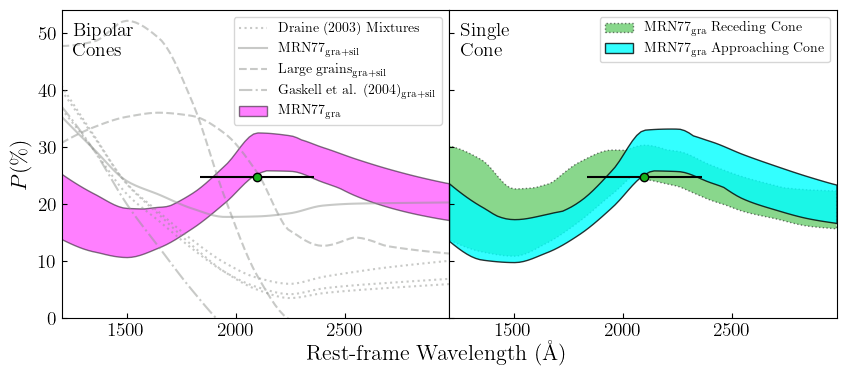

In [19]:
#force_new = True
force_new = False
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,4))#, figsize=(10,4))
plt.subplots_adjust(wspace=0., hspace=0.)


lam_grid = np.arange(1200., 3000., 20.)*u.AA
for ax in axs:
    ax.tick_params(axis='both', which='both', direction='in', labelsize=14)
    ax.set_xlim([np.min(lam_grid.value), np.max(lam_grid.value)])

if force_new or not os.path.exists("min_max_curve.dat"):
    min_curve = np.zeros((len(cone_types), len(lam_grid))) + 1e32
    max_curve = np.zeros(min_curve.shape)
    for ct, cone_type in enumerate(cone_types):
        for ind in np.argwhere(chi2_map[wid][cone_type]<1.0):
            i1, j1, k1 = ind
            curve = 100*pws[cone_type].p((tang_grid[i1]*np.ones(lam_grid.shape), cang_grid[j1]*np.ones(lam_grid.shape), iang_grid[k1]*np.ones(lam_grid.shape), lam_grid))
            #curve = 100*pws_linear[cone_type].p((tang_grid[i1]*np.ones(lam_grid.shape), cang_grid[j1]*np.ones(lam_grid.shape), iang_grid[k1]*np.ones(lam_grid.shape), lam_grid))
            min_curve[ct] = np.where(curve<min_curve[ct], curve, min_curve[ct])
            max_curve[ct] = np.where(curve>max_curve[ct], curve, max_curve[ct])
    np.savetxt("min_curve.{}.dat".format(general_method_interp), min_curve)
    np.savetxt("max_curve.{}.dat".format(general_method_interp), max_curve)
else:
    min_curve = np.loadtxt("min_curve.{}.dat".format(general_method_interp))
    max_curve = np.loadtxt("max_curve.{}.dat".format(general_method_interp))


ax = axs[0]
for mm, osk in enumerate(other_sk):
    oskm = other_sk_models[mm]
    kk = np.argmin(other_chi2[mm])
    ax.plot(lam_grid, 100*osk.p((iang_grid[kk]*np.ones(lam_grid.shape), lam_grid)), c='xkcd:grey',ls=oskm["ls"], label=oskm["label"], alpha=0.5)
ax.fill_between(lam_grid.value, min_curve[2], max_curve[2], color='magenta', alpha=0.5, ec='black',ls='solid', label=r'$\rm MRN77_{\rm gra}$')
ax.legend()

ax = axs[1]
ax.fill_between(lam_grid.value, min_curve[1], max_curve[1], color='xkcd:green', alpha=0.5, ec='black',ls='dotted', label=r'$\rm MRN77_{\rm gra}$ Receding Cone')
ax.fill_between(lam_grid.value, min_curve[0], max_curve[0], color='cyan', alpha=0.8, label=r'$\rm MRN77_{\rm gra}$ Approaching Cone', ec='black')
ax.legend()#loc=(0.67, 0.7))

ax.set_ylim([0., 54.])

for ax in axs:
    for bname in op.pfrac[wid].keys():

        ax.errorbar([bands.bp[bname].barlam().value/(1+op.z[wid])], [op.pfrac[wid][bname]], xerr=[bands.bp[bname].rectwidth().value/2./(1+op.z[wid])], yerr=[op.epfrac[wid][bname]], marker='o', c='xkcd:green', markeredgecolor='black', ecolor='black')



axs[0].set_ylabel(r"$P (\%)$", fontsize=16)
fig.supxlabel(r"Rest-frame Wavelength $(\rm \AA)$", fontsize=16, y=-0.01)

axs[0].text(0.03, 0.85, 'Bipolar\nCones', transform=axs[0].transAxes, ha='left', fontsize=14)
axs[1].text(0.03, 0.85, 'Single\nCone', transform=axs[1].transAxes, ha='left', fontsize=14)

fig.savefig("SKIRTOR_W0204.png", dpi=200, bbox_inches='tight')


In [13]:
# force_new = False# True
# fig, ax = plt.subplots(1)#, figsize=(10,4))#, figsize=(10,4))
# plt.subplots_adjust(wspace=0., hspace=0.)

# ax.tick_params(axis='both', which='both', direction='in', labelsize=14)

# lam_grid = np.arange(1200., 3000., 20.)*u.AA
# ax.set_xlim([np.min(lam_grid.value), np.max(lam_grid.value)])

# # for mm, osk in enumerate(other_sk):
# #     oskm = other_sk_models[mm]
# #     kk = np.argmin(other_chi2[mm])
# #     ax.plot(lam_grid, 100*osk.p((iang_grid[kk]*np.ones(lam_grid.shape), lam_grid)), c='xkcd:grey',ls=oskm["ls"], label=oskm["label"], alpha=0.5)

# if force_new or not os.path.exists("min_max_curve.dat"):
#     min_curve = np.zeros((len(cone_types), len(lam_grid))) + 1e32
#     max_curve = np.zeros(min_curve.shape)
#     for ct, cone_type in enumerate(cone_types):
#         for ind in np.argwhere(chi2_map[wid][cone_type]<1.0):
#             i1, j1, k1 = ind
#             curve = 100*pws[cone_type].p((tang_grid[i1]*np.ones(lam_grid.shape), cang_grid[j1]*np.ones(lam_grid.shape), iang_grid[k1]*np.ones(lam_grid.shape), lam_grid))
#             #curve = 100*pws_linear[cone_type].p((tang_grid[i1]*np.ones(lam_grid.shape), cang_grid[j1]*np.ones(lam_grid.shape), iang_grid[k1]*np.ones(lam_grid.shape), lam_grid))
#             min_curve[ct] = np.where(curve<min_curve[ct], curve, min_curve[ct])
#             max_curve[ct] = np.where(curve>max_curve[ct], curve, max_curve[ct])
#     np.savetxt("min_max_curve.dat", np.array([min_curve[0], min_curve[1], max_curve[0], max_curve[1]]).T)
# else:
#     aux = np.loadtxt("min_max_curve.dat")
#     min_curve = aux[:,:2].T
#     max_curve = aux[:,2:].T
# ax.fill_between(lam_grid.value, min_curve[1], max_curve[1], color='xkcd:green', alpha=0.5, ec='black',ls='dotted', label=r'$\rm MRN77_{\rm gra}$ Receding Cone')
# ax.fill_between(lam_grid.value, min_curve[0], max_curve[0], color='cyan', alpha=0.8, label=r'$\rm MRN77_{\rm gra}$ Approaching Cone', ec='black')



# for bname in op.pfrac[wid].keys():

#     ax.errorbar([bands.bp[bname].barlam().value/(1+op.z[wid])], [op.pfrac[wid][bname]], xerr=[bands.bp[bname].rectwidth().value/2./(1+op.z[wid])], yerr=[op.epfrac[wid][bname]], marker='o', c='xkcd:green', markeredgecolor='black', ecolor='black')

# ax.legend()#loc=(0.67, 0.7))

# ax.set_ylim([0., 45.])

# ax.set_ylabel(r"$P (\%)$", fontsize=16)
# ax.set_xlabel(r"Rest-frame Wavelength $(\rm \AA)$", fontsize=16)

# fig.savefig("SKIRTOR_W0204.png", dpi=200, bbox_inches='tight')


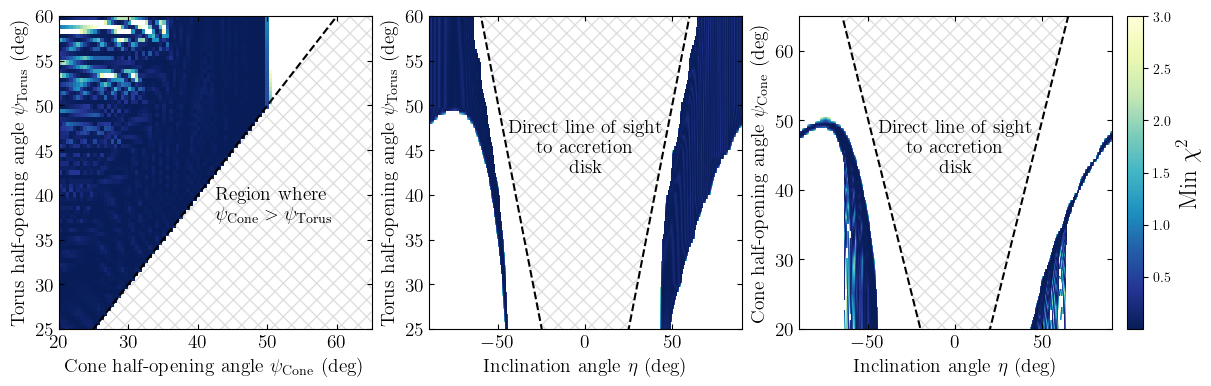

In [22]:
import matplotlib.patches


fig, axs = plt.subplots(1, 3, figsize=(12,6), layout='constrained')
for ax in axs.flatten():
   ax.tick_params(axis='both', direction='in', labelsize=14, bottom=True, top=True, left=True, right=True)

axis_label_fontsize = 14

nt, nc, ni = chi2_map[wid][cone_types[0]].shape

diang = np.mean(iang_grid[1:]-iang_grid[:-1]).value
iang_grid_extended = np.arange(-90., 90.1, diang)*u.deg
nie = len(iang_grid_extended) 

chi2_use = np.ma.zeros((nt, nc, nie))
chi2_use.mask = np.zeros(chi2_use.shape, dtype=bool)

chi2_use[:,:,:ni] = np.copy(chi2_map[wid][cone_types[1]][:,:,::-1])
chi2_use[:,:,nie-ni:] = np.copy(chi2_map[wid][cone_types[0]])
chi2_use.mask[:,:,ni:nie-ni] = True

vmin = np.min(chi2_use)
vmax = 3.0
cmap = 'YlGnBu_r'

II, JJ, KK = np.meshgrid(tang_grid.value, cang_grid.value+10, iang_grid_extended.value, indexing='ij')
chi2_use.mask[(JJ>II) | (np.abs(KK)<II)] = True
chi2_use.mask[chi2_use>vmax] = True

#Torus - Cone
ax = axs[0]
chi2_aux = np.min(chi2_use, axis=2)
cb = ax.imshow(chi2_aux, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap, extent=[np.min(cang_grid.value)+10, np.max(cang_grid.value)+10, np.min(tang_grid.value), np.max(tang_grid.value)])
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot(ax.get_xlim(), np.array(ax.get_xlim()), 'k--') 
ax.fill_between(ax.get_xlim(), np.array(ax.get_xlim()), ax.get_ylim()[0], color="none", hatch="xx", edgecolor="xkcd:gray", linewidth=0.0, alpha=0.3)
ax.set_xlabel(r"Cone half-opening angle $\psi_{\rm Cone}$ (deg)", fontsize=axis_label_fontsize)
ax.set_ylabel(r"Torus half-opening angle $\psi_{\rm Torus}$ (deg)", fontsize=axis_label_fontsize)
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.text(0.50, 0.35, "Region where \n"+r"$\psi_{\rm Cone} > \psi_{\rm Torus}$", fontsize=14, weight='extra bold', fontfamily='sans-serif', transform=ax.transAxes, wrap=True)

#Torus - Inclination
ax = axs[1]
chi2_aux = np.min(chi2_use, axis=1)
ax.imshow(chi2_aux, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap, extent=[np.min(iang_grid_extended.value), np.max(iang_grid_extended.value), np.min(tang_grid.value), np.max(tang_grid.value)])
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--') 
ax.plot(ax.get_xlim(), -np.array(ax.get_xlim()), 'k--') 
ax.fill_betweenx(ax.get_ylim(), -np.array(ax.get_ylim()), np.array(ax.get_ylim()), color="none", hatch="xx", edgecolor="xkcd:gray", linewidth=0.0, alpha=0.3)
ax.set_xlabel(r"Inclination angle $\eta$ (deg)", fontsize=axis_label_fontsize)
ax.set_ylabel(r"Torus half-opening angle $\psi_{\rm Torus}$ (deg)", fontsize=axis_label_fontsize)
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.text(0.5, 0.5, "Direct line of sight \nto accretion \ndisk", ha='center', fontsize=14, weight='extra bold', fontfamily='sans-serif', transform=ax.transAxes)
# ax.plot([45.]*2, ax.get_ylim(), 'k--')
# ax.plot([-45.]*2, ax.get_ylim(), 'k--')

#Cone - Inclination
ax = axs[2]
chi2_aux = np.min(chi2_use, axis=0)
cb = plt.imshow(chi2_aux, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap, extent=[np.min(iang_grid_extended.value), np.max(iang_grid_extended.value), np.min(cang_grid.value)+10, np.max(cang_grid.value)+10])
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot(ax.get_xlim(), np.array(ax.get_xlim()), 'k--') 
ax.plot(ax.get_xlim(), -np.array(ax.get_xlim()), 'k--') 
ax.fill_betweenx(ax.get_ylim(), -np.array(ax.get_ylim()), np.array(ax.get_ylim()), color="none", hatch="xx", edgecolor="xkcd:gray", linewidth=0.0, alpha=0.3)
plt.xlabel(r"Inclination angle $\eta$ (deg)", fontsize=axis_label_fontsize)
plt.ylabel(r"Cone half-opening angle $\psi_{\rm Cone}$ (deg)", fontsize=axis_label_fontsize)
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.text(0.5, 0.5, "Direct line of sight \nto accretion \ndisk", ha='center', fontsize=14, weight='extra bold', fontfamily='sans-serif', transform=ax.transAxes)
p = matplotlib.patches.Circle((60.,33.5), 1.)
#ax.add_artist(p)
# ax.plot([45.]*2, ax.get_ylim(), 'k--')
# ax.plot([-45.]*2, ax.get_ylim(), 'k--')

fig.colorbar(cb, fraction=0.05).set_label(label=r'Min $\chi^2$',size=18)

plt.show()
fig.savefig("W0204_chi2maps.png", dpi=200, bbox_inches='tight')

In [15]:
cond = (KK==60)
nn = np.argmin(chi2_use[cond], axis=None)
IIx = II[cond]
JJx = JJ[cond]
IIx[nn], JJx[nn]

(35.0, 33.5)

In [16]:
chi2_use[(JJ==33.5) & (KK==60.0) & (II==40.0)]

masked_array(data=[0.0387497145678057],
             mask=[False],
       fill_value=1e+20)

In [ ]:
#Gas mass estimate for the best-fit cone with the MRN77 dust. 
for cone_type in cone_types:
    i, j, k = np.unravel_index(np.argmin(chi2_map[wid][cone_type], axis=None), chi2_map[wid][cone_type].shape)
    print(tang_grid[i], cang_grid[j], iang_grid[k], chi2_map[wid][cone_type].min())

    tau_V = 0.1
    delta_psi_c = 10*u.deg #10*u.deg
    psi_c = np.array([10, 38, 40])*u.deg #cang_grid[j]
    X = 1.5e-23*u.cm**2
    L = 10*u.kpc
    Rv = 3.1

    Mg = (2.5/np.log(10.)) * np.pi/3. * m_p * tau_V/(X*Rv) * L**2 * np.cos(psi_c-delta_psi_c/2.)*(np.tan(psi_c))**2
    print((Mg/M_sun).to(u.dimensionless_unscaled)/1e9)

    #Now the obscuration of a light ray going through the dusty section of the cone at mid-height
    d = 0.5*L*(np.tan(psi_c)-np.tan(psi_c-delta_psi_c))
    n_H = (2.5/np.log(10.)) * tau_V/(X*Rv) * np.cos(psi_c-delta_psi_c/2.)/L
    print(d, n_H.to(u.cm**-3), X*n_H*d)


32.5 deg 21.0 deg 56.0 deg 7.689583731337499e-10
[0.06065613 1.00254534 1.12949556]
[0.8816349  1.24788097 1.30874681] kpc [0.07538155 0.06346178 0.06198482] 1 / cm3 [0.00307607 0.00366545 0.00375477]
50.0 deg 35.5 deg 61.0 deg 1.4407787221813311e-08
[0.06065613 1.00254534 1.12949556]
[0.8816349  1.24788097 1.30874681] kpc [0.07538155 0.06346178 0.06198482] 1 / cm3 [0.00307607 0.00366545 0.00375477]
28.0 deg 15.0 deg 48.5 deg 3.83571358380841e-08
[0.06065613 1.00254534 1.12949556]
[0.8816349  1.24788097 1.30874681] kpc [0.07538155 0.06346178 0.06198482] 1 / cm3 [0.00307607 0.00366545 0.00375477]


In [28]:
psi_cs = JJ[(~chi2_use.mask) & (KK>0)]
print(np.min(psi_cs), np.max(psi_cs), np.median(psi_cs))
#Mg = (2.5/np.log(10.)) * np.pi/3. * m_p * tau_V/(X*Rv) * L**2 * np.cos(psi_c-delta_psi_c/2.)*(np.tan(psi_c))**2
#print((Mg/M_sun).to(u.dimensionless_unscaled)/1e9)

20.0 48.5 35.0
